In [1]:
import requests
from bs4 import BeautifulSoup
from lxml import html
from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus, unquote

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

In [2]:
# 플랏 스타일
plt.style.use('fivethirtyeight')

# - 표시 오류 해결
mpl.rcParams['axes.unicode_minus'] = False

# 한글폰트 굴림으로 설정
font_location = 'C:/Windows/Fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname = font_location).get_name()
rc('font', family=font_name)
mpl.rcParams.update({'font.size': 15})

# 보건복지부 코로나19 감염 현황

In [3]:
my_api_key = "sZiMF2BEFca0NrdzttDLIMu0bsnvgk9QMBeIMLqbnkDplTsBA5Zc%2BCGZvJlEcFnPiLK%2Fvi3j%2FIKxXUQ7lbXwgQ%3D%3D"

In [4]:
def crowling_korea_covid_data_and_preprocessing(api_key):
    '''
    보건복지부 코로나19 감염 현황 https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043376
    데이터 크롤링 및 이상한 데이터 전처리
    
    api_key : url에서 신청했을 때 발급받는 service key
    '''
    
    # url 및 parameter 설정
    url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson"

    service_key = unquote(api_key)

    queryParams = "?" + urlencode(
        {
            quote_plus("serviceKey") : service_key,
            quote_plus("numOfRows") : "500",
            quote_plus("startCreateDt") : "20200101",
            quote_plus("endCreateDt") : "20201031"
        }
    )

    # 오픈api 페이지 크롤링
    response = requests.get(url + queryParams).text.encode("utf-8")
    xmlobj = BeautifulSoup(response, "lxml-xml")
    rows = xmlobj.findAll("item")
        
    # 반복문을 돌면서 크롤링페이지의 데이터를 딕셔너리에 저장
    rowdict = {'stateDt' : [],
              'decideCnt' : []}

    for element in rows:
        row = element.find_all()

        for ele in row:
            if ele.name in ['stateDt', 'decideCnt']:
                rowdict[ele.name].append(ele.text)
                
    # 데이터프레임화
    rowdict_korean = dict((i, j) for i, j in zip(['기준일', '확진자수'], list(rowdict.values())))
    df = pd.DataFrame(rowdict_korean)

    df['기준일'] = pd.to_datetime(df['기준일'])
    df['확진자수'] = pd.to_numeric(df['확진자수'])
    df.sort_values(by='기준일', inplace=True, ascending=True)
    df.reset_index(drop=True, inplace=True)

    # 전처리
    ## 같은 날짜로 데이터 여러개 있길래 삭제
    delete_rownumber1 = []

    for number in range(1, len(df['기준일'])):
        yesterday_date = df['기준일'][number-1]
        today_date = df['기준일'][number]

        if today_date == yesterday_date:
            delete_rownumber1.append(number)
            
    df = df.drop(delete_rownumber1)
    df.reset_index(drop=True, inplace=True)
    
    ## 어제보다 오늘의 값이 
    delete_rownumber2 = []

    for number in range(1, len(df['확진자수'])):
        yesterday_decide = df['확진자수'][number-1]
        today_decide = df['확진자수'][number]

        if today_decide < yesterday_decide:
            delete_rownumber2.append(number)

    df = df.drop(delete_rownumber2)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [5]:
cumulated_covid19_korea = crowling_korea_covid_data_and_preprocessing(my_api_key)

In [6]:
cumulated_covid19_korea.head(-5)

,기준일,확진자수
0,2020-01-01,0
1,2020-02-02,2
2,2020-02-03,15
3,2020-02-05,19
4,2020-02-06,23
...,...,...
263,2020-10-22,25543
264,2020-10-23,25698
265,2020-10-24,25775
266,2020-10-25,25836


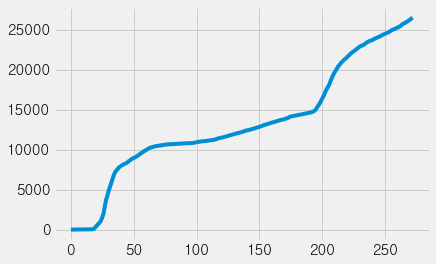

In [7]:
plt.plot(cumulated_covid19_korea['확진자수'])
plt.show()

In [8]:
# cumulated_covid19_korea.to_csv("covid19_korea.csv")

### 주차별 확진자 수 그래프

In [9]:
def weekly_covid19_plot(df):
    '''cumulated_covid19_korea 받아서 주차별 확진자 수 그래프 출력'''
    
    df['일일확진자수'] = pd.to_numeric(df['확진자수'].diff())
    resampled_df = df.resample('W', on='기준일').sum()
    
    week_index = ['week' + str(i) for i in range(1, 45)]
    resampled_df.index = week_index
    
    color_palette = sns.color_palette("Reds_d", resampled_df.shape[0])
    color_rank = resampled_df['일일확진자수'].argsort().argsort()

    plt.figure(figsize=(12, 6))
    sns.barplot(resampled_df.index, resampled_df['일일확진자수'],
                palette=np.array(color_palette[::-1])[color_rank])

    plt.axvline(x=7.5, linewidth=2.5, color='r', label='포스트 코로나 시작')
    plt.axvline(x=32.5, linewidth=2.5, color='b', label='2차 확산')
    plt.legend(loc=1, fontsize=14)

    plt.title('전국 주차별 확진자 수', fontsize=25)
    plt.xticks(rotation=45, size=12.5, ha='right')
    plt.ylabel('')

    plt.show()

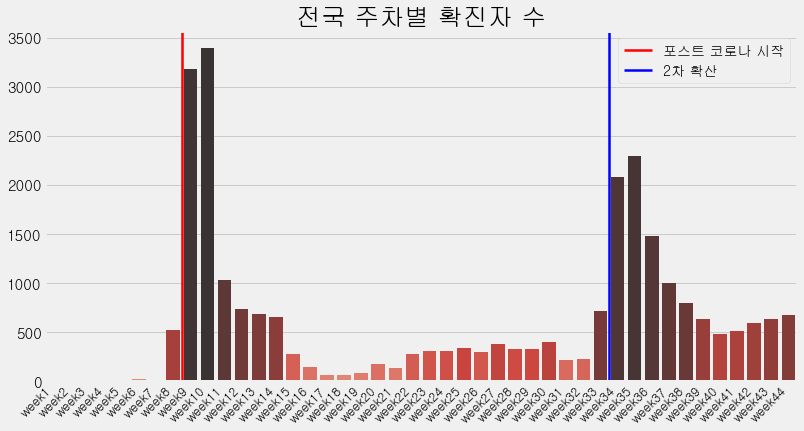

In [10]:
weekly_covid19_plot(cumulated_covid19_korea)